# Mismatch tests

To determine the reason for the noisy mismatch curves when introducing the (3,2,0,1) mode into a (2,2,n,1) overtone model. And to determine why the overtone model, when fit using the GP, and mismatch computed with the inverse noise covariance matrix produces an oscillatory feature with the frequency of the (2,2,3,1) mode. 

Tests:

Fixes: noise matrix was wrong for WN 

Overtone model only:

- Compare to LS with Mf and Chif turned off

LS perfectly agrees with WN as expected. 

- Compare to LS with Mf and Chif turned on 

LS no longer agrees with WN in the unweighted case. There's no reason they should. In the weighted case, they perfectly agree - why is this? 

- Overtone model with (2,2,3,1) removed only - does the osc change to (2,2,4,1)? 

Oscillation changes to (2,2,2,1) but significantly dampened. Removing (2,2,2,1) removes oscillations entirely. I haven't checked but 
my guess is higher overtones are making such a negligable contribution that the these lower overtones are being unstably fit and are 
sufficiently big to be noticeable. 

- Overtone model with (2,2,3,1) and above removed. Does osc stop entirely? 

Yes. The line is perfectly flat. AND it's below the WN line by a tiny amount. Annoyingly adding in n=3 does not reintroduce oscillations. Only n=7 gives the pronounced oscillations and to a lesser extent n=6. 

Overtone + (3,2,0,1):

- Compare to LS. Does this look as unstable? 

It looks considerably better but yes. 

- Turn off Mf and Chif

Slightly improves things

- Reduce number of overtones 



In [48]:
import sys
from pathlib import Path

# Get the current notebook's directory
notebook_dir = Path().resolve()

# Add the parent directory of the module to the Python path
sys.path.append(str(notebook_dir.parent))

In [49]:
import qnmfits
import numpy as np
import scipy
import corner
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import to_hex
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from qnmfits.spatial_mapping_functions import * 
from bayes_qnm_GP_likelihood import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [50]:
#plt.style.use("stylesheet.mplstyle")
fig_width = 246.0 * (1.0 / 72.27)
fig_height = fig_width / 1.618

colors = [
    "#395470",  # soft viridis-style blue
    "#5A7A87",  # pastel twilight blue-teal
    "#A4C9A7",  # pastel sage
    "#D3C76A",  # pastel olive
    "#E9DF83",  # slightly darker pastel yellow
]

matte_viridis = LinearSegmentedColormap.from_list('custom_colormap', colors)

In [ ]:
id = "0001"

sim_main = SXS_CCE(id, lev="Lev5", radius="R2")
sim_lower = SXS_CCE(id, lev="Lev4", radius="R2")

# Align waveforms (for noise floor calcs) and put them on the same time grid 

time_shift = get_time_shift(sim_main, sim_lower)
sim_lower.zero_time = -time_shift
sim_lower.time_shift()

new_times = np.arange(sim_main.times[0], sim_main.times[-1], 0.1)
sim_main_interp = sim_interpolator(sim_main, new_times)
sim_lower_interp = sim_interpolator(sim_lower, new_times)

N_MAX = 7
T = 100

qnm_list = [(2, 2, n, 1) for n in np.arange(0, N_MAX + 1)]  + [(3, 2, 0, 1)] 
spherical_modes = [(2, 2)]

# Get the true, reference values for mass and spin 

chif_mag_ref = sim_main.chif_mag
Mf_ref = sim_main.Mf

T0s = np.linspace(-25, 75, 50)

T0_REF = 17

INCLUDE_MF = True
INCLUDE_CHIF = True # Remember to change ref params in LS too! 

### Determine mass and spin as free parameters for least-squares

In [166]:
def Mf_chif_mismatch(Mf_chif_mag_list, t0, T, spherical_modes):
    Mf, chif_mag = Mf_chif_mag_list
    best_fit = qnmfits.multimode_ringdown_fit(
                sim_main.times, sim_main.h, qnm_list, Mf, chif_mag, t0, t0_method="geq", T=T, spherical_modes=spherical_modes
                )
    return best_fit["mismatch"]

In [167]:
initial_params = (Mf_ref, chif_mag_ref)

Mf_RANGE = (Mf_ref*0.5, Mf_ref*1.5)
chif_mag_RANGE = (0.1, 0.99)
bounds = (Mf_RANGE, chif_mag_RANGE)

result = minimize(
            Mf_chif_mismatch,
            initial_params,
            args=(T0_REF, T, spherical_modes),
            method="Nelder-Mead",
            bounds=bounds,
        )

Mf_t0 = result.x[0]
chif_t0 = result.x[1] 

Mfs_chifs = np.zeros((len(T0s), 2))

for i, t0 in enumerate(T0s):

    args = (t0, T, spherical_modes)

    result = minimize(
            Mf_chif_mismatch,
            initial_params,
            args=args,
            method="Nelder-Mead",
            bounds=bounds,
        )

    Mfs_chifs[i] = result.x
    initial_params = result.x

In [168]:
notebook_dir = Path().resolve()
data_dir = notebook_dir.parent / "data"

In [169]:
# Get the main kernel parameters

with open(data_dir / 'tuned_params.pkl', 'rb') as f:
            params = pickle.load(f)

tuned_param_dict_main = params[id]

In [170]:
# Get the white noise kernel parameters 

with open(data_dir / 'param_dict_sim_lm_full.pkl', 'rb') as f:
    param_dict_sim_lm = pickle.load(f)

tuning_hyperparams_s = [0.29245605468749936]  # This value was determined in get_kernel_params_alt.ipynb

hyperparam_rule_dict_s = {
    "sigma_max": "multiply",
}

tuned_param_dict_wn = {mode: get_new_params(param_dict_sim_lm[id][mode], tuning_hyperparams_s, hyperparam_rule_dict_s) for mode in param_dict_sim_lm[id]}

### Get the fit data at a range of t0s

In [ ]:
unweighted_mismatches_LS = np.zeros((len(T0s)))
weighted_mismatches_LS = np.zeros((len(T0s)))

unweighted_mismatches_WN = np.zeros((len(T0s)))
weighted_mismatches_WN = np.zeros((len(T0s)))

unweighted_mismatches_GP = np.zeros((len(T0s)))
weighted_mismatches_GP = np.zeros((len(T0s)))

unweighted_mismatches_noise = np.zeros((len(T0s)))
weighted_mismatches_noise = np.zeros((len(T0s)))

amplitudes_LS = np.zeros((len(T0s), len(qnm_list)))

ampltiudes_WN = np.zeros((len(T0s), len(qnm_list)))
amplitudes_WN_10_percentiles = np.zeros((len(T0s), len(qnm_list)))
amplitudes_WN_25_percentiles = np.zeros((len(T0s), len(qnm_list)))
amplitudes_WN_50_percentiles = np.zeros((len(T0s), len(qnm_list)))
amplitudes_WN_75_percentiles = np.zeros((len(T0s), len(qnm_list)))
amplitudes_WN_90_percentiles = np.zeros((len(T0s), len(qnm_list)))

amplitudes_GP = np.zeros((len(T0s), len(qnm_list)))
amplitudes_GP_10_percentiles = np.zeros((len(T0s), len(qnm_list)))
amplitudes_GP_25_percentiles = np.zeros((len(T0s), len(qnm_list)))
amplitudes_GP_50_percentiles = np.zeros((len(T0s), len(qnm_list)))
amplitudes_GP_75_percentiles = np.zeros((len(T0s), len(qnm_list)))
amplitudes_GP_90_percentiles = np.zeros((len(T0s), len(qnm_list)))

significances_WN = np.zeros((len(T0s), len(qnm_list)))
significances_GP = np.zeros((len(T0s), len(qnm_list)))

for i, t0 in enumerate(T0s):

    print(f"t0 = {t0}")

    Mf = Mfs_chifs[i, 0]
    chif_mag = Mfs_chifs[i, 1]

    fit_GP = qnm_BGP_fit(
            sim_main.times,
            sim_main.h,
            qnm_list,
            Mf_t0,
            chif_t0,
            t0,
            tuned_param_dict_main,
            kernel_main,
            t0_method="geq",
            T=T,
            spherical_modes=spherical_modes,
            include_chif=INCLUDE_CHIF,
            include_Mf=INCLUDE_MF,
        )
    
    fit_WN = qnm_BGP_fit(
            sim_main.times,
            sim_main.h,
            qnm_list,
            Mf_ref,
            chif_mag_ref,
            t0,
            tuned_param_dict_wn,
            kernel_s,
            t0_method="geq",
            T=T,
            spherical_modes=spherical_modes,
            include_chif=INCLUDE_CHIF,
            include_Mf=INCLUDE_MF,
        )
    
    fit_LS = qnmfits.multimode_ringdown_fit(
                        sim_main.times,
                        sim_main.h,
                        qnm_list,
                        Mf_ref,
                        chif_mag_ref,
                        t0,
                        T=T,
                        spherical_modes=spherical_modes,
                        t0_method="closest",
                    )
    
    # Mismatch
    
    unweighted_mismatches_LS[i] = unweighted_mismatch(fit_LS['model'], fit_LS['data'])
    weighted_mismatches_LS[i] = weighted_mismatch(fit_LS['model'], fit_LS['data'], fit_GP['inv_noise_covariance']) 

    unweighted_mismatches_WN[i] = unweighted_mismatch(fit_WN['model'], fit_WN['data'])
    weighted_mismatches_WN[i] = weighted_mismatch(fit_WN['model'], fit_WN['data'], fit_GP['inv_noise_covariance']) 

    unweighted_mismatches_GP[i] = unweighted_mismatch(fit_GP['model'], fit_GP['data'])
    weighted_mismatches_GP[i] = weighted_mismatch(fit_GP['model'], fit_GP['data'], fit_GP['inv_noise_covariance'])

    mm_mask = (sim_main_interp.times >= t0 - 1e-9) & (sim_main_interp.times < t0+T - 1e-9)
    mm_times = sim_main_interp.times[mm_mask]
    main_data = {(2, 2): sim_main_interp.h[(2, 2)][mm_mask]}
    lower_data = {(2, 2): sim_lower_interp.h[(2, 2)][mm_mask]}
    unweighted_mismatches_noise[i] = unweighted_mismatch(main_data, lower_data)
    weighted_mismatches_noise[i] = weighted_mismatch(main_data, lower_data, fit_GP['inv_noise_covariance'])

    # Amplitude 

    amplitudes_LS[i, :] = np.abs(fit_LS['C'])
    ampltiudes_WN[i, :] = fit_WN['mean_abs_amplitude']
    amplitudes_GP[i, :] = fit_GP['mean_abs_amplitude']
    
    amplitudes_WN_10_percentiles[i, :], \
    amplitudes_WN_25_percentiles[i, :], \
    amplitudes_WN_50_percentiles[i, :], \
    amplitudes_WN_75_percentiles[i, :], \
    amplitudes_WN_90_percentiles[i, :] = fit_WN['abs_amplitude_percentiles']
    
    amplitudes_GP_10_percentiles[i, :], \
    amplitudes_GP_25_percentiles[i, :], \
    amplitudes_GP_50_percentiles[i, :], \
    amplitudes_GP_75_percentiles[i, :], \
    amplitudes_GP_90_percentiles[i, :] = fit_GP['abs_amplitude_percentiles']

    # Significance 

    significances_WN[i, :] = get_significance_list(qnm_list, fit_WN['mean'], fit_WN['fisher_matrix']) 
    significances_GP[i, :] = get_significance_list(qnm_list, fit_GP['mean'], fit_GP['fisher_matrix'])

t0 = -25.0
t0 = -22.959183673469386
t0 = -20.918367346938776
t0 = -18.877551020408163
t0 = -16.836734693877553
t0 = -14.795918367346939
t0 = -12.755102040816325
t0 = -10.714285714285714
t0 = -8.673469387755102
t0 = -6.632653061224488
t0 = -4.591836734693878
t0 = -2.5510204081632644
t0 = -0.5102040816326507
t0 = 1.5306122448979593
t0 = 3.571428571428573
t0 = 5.612244897959183
t0 = 7.653061224489797
t0 = 9.693877551020407
t0 = 11.734693877551024
t0 = 13.775510204081634
t0 = 15.816326530612244
t0 = 17.85714285714286
t0 = 19.89795918367347
t0 = 21.93877551020408
t0 = 23.9795918367347
t0 = 26.02040816326531
t0 = 28.06122448979592
t0 = 30.10204081632653
t0 = 32.142857142857146
t0 = 34.183673469387756
t0 = 36.224489795918366
t0 = 38.26530612244898
t0 = 40.30612244897959
t0 = 42.34693877551021
t0 = 44.38775510204081
t0 = 46.42857142857143
t0 = 48.46938775510205
t0 = 50.51020408163265
t0 = 52.55102040816327
t0 = 54.591836734693885
t0 = 56.63265306122449
t0 = 58.673469387755105
t0 = 60.714285714

# Mismatch Plot

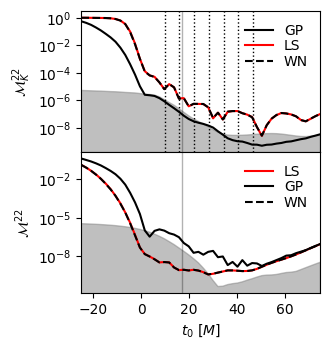

In [172]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(fig_width, fig_height*1.7), sharex=True, gridspec_kw={'hspace': 0})
colors = matte_viridis(np.linspace(0, 1, 1))

ax1.axvline(T0_REF, color="k", alpha=0.3, lw=1)
ax1.plot(T0s, weighted_mismatches_GP, label="GP", color='k')
ax1.plot(T0s, weighted_mismatches_LS, label="LS", color='r', ls='-')
ax1.plot(T0s, weighted_mismatches_WN, label="WN", ls='--', color='k')
ax1.fill_between(T0s, 0, weighted_mismatches_noise, color="grey", alpha=0.5)
ax1.set_xlim(T0s[0], T0s[-1])
ax1.set_ylabel(r"$\mathcal{M}^{22}_K$")
ax1.set_yscale("log")
ax1.legend()
_ = ax1.legend(ncol=1, frameon=False, loc="upper right", labelspacing=0.1)

T_test = np.pi * 2 / qnmfits.qnm.omega(4,2,0,1, sim_main.chif_mag, Mf=sim_main.Mf).real 
for i in np.arange(-1, 6, 1):
    ax1.axvline(16 + i*T_test, color="k", alpha=1, lw=1, ls=':')

ax2.axvline(T0_REF, color="k", alpha=0.3, lw=1)
ax2.plot(T0s, unweighted_mismatches_LS, label="LS", color='r', ls='-')
ax2.plot(T0s, unweighted_mismatches_GP, label="GP", color='k')
ax2.plot(T0s, unweighted_mismatches_WN, label="WN", ls='--', color='k')
ax2.fill_between(T0s, 0, unweighted_mismatches_noise, color="grey", alpha=0.5)
ax2.set_xlim(T0s[0], T0s[-1])
ax2.set_xlabel("$t_0 \ [M]$")
ax2.set_ylabel(r"$\mathcal{M}^{22}$")
ax2.set_yscale("log")
_ = ax2.legend(ncol=1, frameon=False, loc="upper right", labelspacing=0.1)

plt.tight_layout()
plt.show()
fig.savefig("mismatch_no_above_3.pdf", bbox_inches="tight")